# **CUPI - Coink User Performance Index**

In this notebook, we will explore the performance of Coink users. To do so, we will conduct an exploratory data analysis to better understand user behavior, followed by a detailed user analysis. In addition, we will introduce the Coink User Performance Index (CUPI), a metric that will allow us to evaluate the performance of platform users. We will use the K-means algorithm to segment Coink users into different groups and visualize clusters and CUPI to better understand the behavior of the different user groups. Let's get started!

# **Exploratory Data Analysis**

### Import the necessary libraries and load the deposit_oinks.csv dataset.


In [1]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
%matplotlib inline

warnings.filterwarnings("ignore")

df = pd.read_csv("../data/depositos_oinks.csv")
df.head(3)


,Unnamed: 0,user_id,operation_value,operation_date,maplocation_name,user_createddate
0,0,0e52d550-ae23-407a-9b1f-6e5fb1f066ab,273850.0,2022-01-14 13:07:56,CC Plaza de las Américas - Plaza Mariposa,2022-01-09 19:23:18.332689
1,1,975ed41e-d891-4c23-aeba-06363019d8e3,900.0,2022-02-06 13:11:25,CC Plaza de las Américas - Plaza Mariposa,2022-01-10 15:19:29.419075
2,2,f9043545-dfc2-402f-a8c7-0a61f21cb719,1800.0,2022-02-23 14:01:56,Universidad de los Andes - ML Piso 5,2021-08-25 12:44:48.524941


### Prepare the data for easier analysis.


In [2]:
# Convert operation_date and user_createddate to datetime format
df["operation_date"] = pd.to_datetime(df["operation_date"])
df["user_createddate"] = pd.to_datetime(df["user_createddate"])

# Change the locations long name to a shorter one
df["maplocation_name"] = df["maplocation_name"].replace(
    {
        "CC Plaza de las Américas  - Plaza Mariposa": "CC Las Américas",
        "CC Los Molinos - Zona Montaña Nivel 2": "CC Los Molinos",
        "Universidad de los Andes - ML Piso 5": "Uni. de los Andes",
    }
)

# Define a color palette
colors = ["#FF1493", "#FFFF00", "#00FF00",
          "#00BFFF", "#FFA500", "#FF00FF", "#00FFFF"]


### Visualize the dataset to gain a better understanding of the business.

- **Boxplot of Operation Values:** This plot allows us to visualize the distribution of the amounts deposited by users.


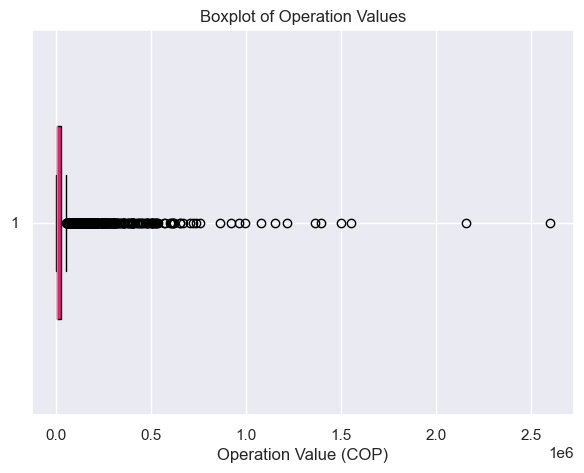

In [3]:
plt.figure(figsize=(7, 5))
sns.set(style="darkgrid")
plt.boxplot(
    df["operation_value"],
    vert=False,
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor=colors[0]),
)
plt.xlabel("Operation Value (COP)")
plt.title("Boxplot of Operation Values")
plt.show()


The range of values is from 0 to 2.5 million pesos, there are no negative values, and most of the values are concentrated in the first quartile. This could be because users use the application to save small amounts of money consistently.

- **Histogram of Operation Values:** The histogram would allow us to observe the distribution of deposit amounts in more detail, enabling us to identify the frequency of certain values and how they group together.


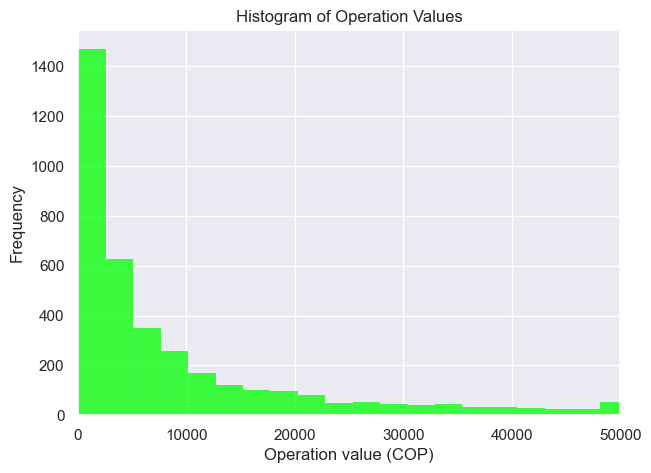

In [4]:
plt.figure(figsize=(7, 5))
sns.set(style="darkgrid")
sns.histplot(data=df, x="operation_value", kde=False, color=colors[2])
plt.xlabel("Operation value (COP)")
plt.ylabel("Frequency")
plt.title("Histogram of Operation Values")
plt.xlim(0, 50000)
plt.show()


The vast majority of values are concentrated in operations of less than 20k pesos, and almost half of the deposits are for 2500 pesos or less. This supports the idea that Oinks are primarily being used for small-scale savings.

- **Scatterplot of Operation Values over Time:** This plot would allow us to see how deposits have been distributed over time, enabling us to identify patterns of behavior and trends.


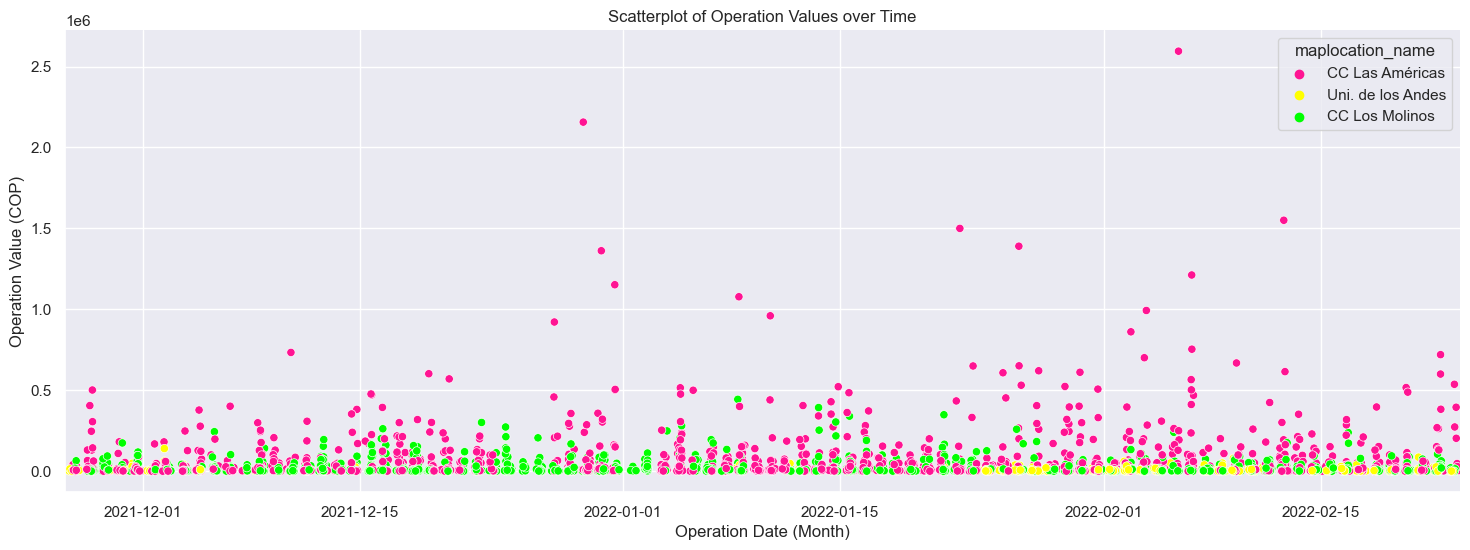

In [5]:
plt.figure(figsize=(18, 6))
sns.set(style="darkgrid")
sns.scatterplot(
    data=df,
    x="operation_date",
    y="operation_value",
    hue="maplocation_name",
    palette=colors,
)
plt.xlim(datetime(2021, 11, 26), datetime(2022, 2, 24))
plt.xlabel("Operation Date (Month)")
plt.ylabel("Operation Value (COP)")
plt.title("Scatterplot of Operation Values over Time")
sns.despine()


The general trend is that the operation values are increasing over time. CC Plaza las Américas is the most important Oink in terms of the value of operations performed. The Oink of the Universidad de los Andes is becoming more important despite the low operation values. The Oink of CC Los Molinos handles intermediate values, and their values decreased slightly in the last month (February).

- **Stacked Bar Chart of Operations per Month and Location:** This chart would allow us to visualize the number of deposits made at each of the Oinks locations and how these deposits are distributed over the months. This would enable us to identify patterns of behavior by location and month, which could help us make decisions to improve the performance of each location.


<Figure size 700x500 with 0 Axes>

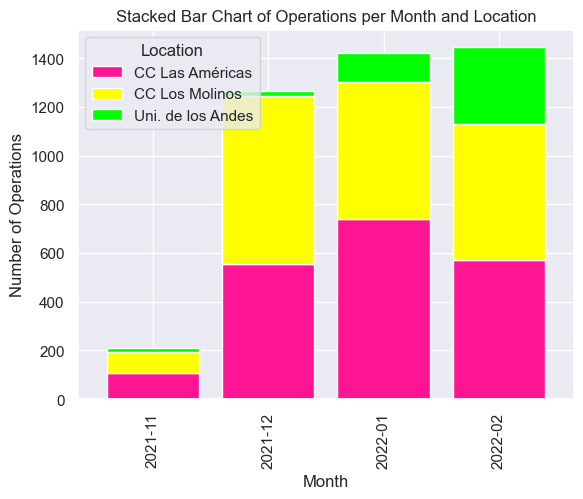

In [6]:
df_month = (
    df.groupby([pd.Grouper(key="operation_date", freq="M"), "maplocation_name"])
    .size()
    .unstack(fill_value=0)
)
df_month.index = df_month.index.strftime("%Y-%m")
plt.figure(figsize=(7, 5))
df_month.plot(kind="bar", stacked=True, color=colors, width=0.8)
plt.xlabel("Month")
plt.ylabel("Number of Operations")
plt.title("Stacked Bar Chart of Operations per Month and Location")
plt.legend(title="Location", loc="upper left")
plt.show()


CC Plaza las Américas and CC Los Molinos Oinks dominate most of the operations in almost the same percentage; however, their growth is almost uniform. The Oink of the Universidad de los Andes has a lower percentage of operations, but it shows exponential growth, going from less than 5% of the total operations in November to almost 25% in February.

- **Stacked Bar Chart of Operation Value per Month and Location:** This chart would allow us to see the total amount of money deposited at each Oink location over time. We could identify patterns of behavior in terms of the amount of money deposited by location and month, which could help us identify trends and make decisions to improve the profitability of each location.


<Figure size 700x500 with 0 Axes>

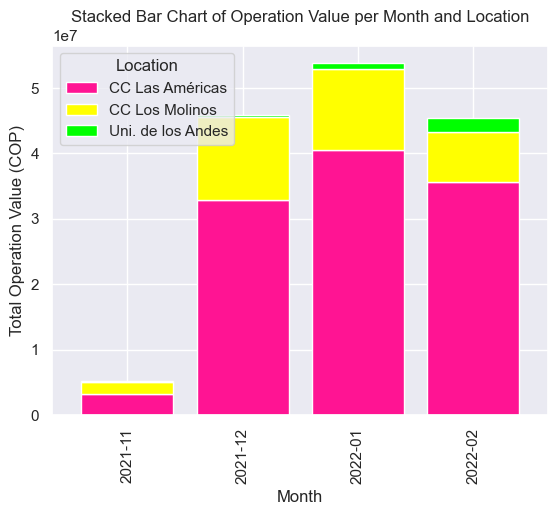

In [7]:
df_month_value = (
    df.groupby([pd.Grouper(key="operation_date", freq="M"), "maplocation_name"])[
        "operation_value"
    ]
    .sum()
    .unstack(fill_value=0)
)
df_month_value.index = df_month_value.index.strftime("%Y-%m")
plt.figure(figsize=(7, 5))
df_month_value.plot(kind="bar", stacked=True, color=colors, width=0.8)
plt.xlabel("Month")
plt.ylabel("Total Operation Value (COP)")
plt.title("Stacked Bar Chart of Operation Value per Month and Location")
plt.legend(title="Location", loc="upper left")
plt.show()


The Oink of CC Plaza las Américas registers most of the deposits, representing more than 75% of the total money deposited in all months. This indicates that this location is very important for the company in terms of revenue.

- **Stacked Bar Chart of Operations per Day of the Week and Location:** This chart would allow us to identify patterns of behavior in terms of the number of deposits made by day of the week and by location. We could identify, for example, if there are certain days of the week when more deposits are made at a specific location, or if there are certain days when more deposits are made at all locations in general. This information could be useful for optimizing the operation of each location and increasing the number of deposits made.


<Figure size 700x500 with 0 Axes>

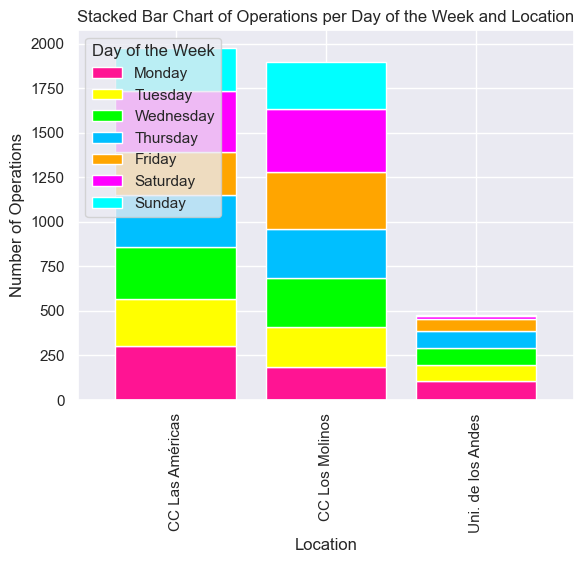

In [8]:
df_day = (
    df.groupby(["maplocation_name", df["operation_date"].dt.day_name()])
    .size()
    .unstack(fill_value=0)
)
days_of_week = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
df_day = df_day.reindex(columns=days_of_week)
plt.figure(figsize=(7, 5))
df_day.plot(kind="bar", stacked=True, color=colors, width=0.8)
plt.xlabel("Location")
plt.ylabel("Number of Operations")
plt.title("Stacked Bar Chart of Operations per Day of the Week and Location")
plt.legend(title="Day of the Week", loc="upper left")
plt.show()


We observe that there is no activity on Saturdays and Sundays at the Oink located in Universidad de los Andes, while at the Oink in CC Plaza las Américas, Monday and Saturday are important days, and at the Oink in CC Los Molinos, Friday and Saturday are important. This information could be useful for adjusting work schedules, and planning marketing campaigns and promotions on different days of the week and locations.


# **Detailed User Analysis**

### Let's create a new dataset with columns focused on the user


In [9]:
users = pd.DataFrame(df["user_id"].unique(), columns=["user_id"])


- **Total deposits:** This column would allow knowing how much a customer has deposited in total, which could be useful for classifying customers into different spending categories.


In [10]:
total_deposits = df.groupby("user_id")["operation_value"].sum().reset_index()
total_deposits.columns = ["user_id", "total_deposits"]
users = users.merge(total_deposits, on="user_id", how="left")


- **Average deposit amount:** This column would allow knowing the average amount deposited by a customer, which could be useful for classifying customers into different income levels.


In [11]:
average_deposit_amount = df.groupby(
    "user_id")["operation_value"].mean().reset_index()
average_deposit_amount.columns = ["user_id", "average_deposit_amount"]
users = users.merge(average_deposit_amount, on="user_id", how="left")


- **Deposit frequency:** This column would allow knowing how often a customer makes deposits, which could be useful for classifying customers into different levels of commitment or loyalty.


In [12]:
deposit_count = df.groupby("user_id")["operation_value"].count().reset_index()
deposit_count.columns = ["user_id", "deposit_count"]
users = users.merge(deposit_count, on="user_id", how="left")
users = users.merge(
    df[["user_id", "user_createddate"]].drop_duplicates(), on="user_id", how="left"
)
users["deposit_frequency"] = users["deposit_count"] / (
    (pd.to_datetime("2022-02-25") -
     pd.to_datetime(users["user_createddate"])).dt.days
    + 1
)
users = users.drop("user_createddate", axis=1)


- **Customer tenure:** This column would allow knowing how long a customer has been using the platform, which could be useful for classifying customers into different levels of experience and loyalty.


In [13]:
customer_tenure = df.groupby("user_id")["user_createddate"].min().reset_index()
customer_tenure.columns = ["user_id", "customer_tenure"]
customer_tenure["customer_tenure"] = (
    pd.to_datetime("2022-02-25") - customer_tenure["customer_tenure"]
).dt.days
users = users.merge(customer_tenure, on="user_id", how="left")


- **Days since last deposit:** This column could be useful for identifying behavior patterns and also for segmenting users according to their level of activity in the application.


In [14]:
user_last_deposit = df.groupby("user_id")["operation_date"].max().reset_index()
user_last_deposit["days_since_last_deposit"] = (
    pd.to_datetime("2022-02-25") - user_last_deposit["operation_date"]
).dt.days
user_last_deposit.drop(columns=["operation_date"], inplace=True)
users = users.merge(user_last_deposit, on="user_id", how="left")


- **Percentage of deposits in each Oink:** This column would allow knowing the percentage of deposits made in each Oink, which could be useful for analyzing customer preferences and behavior patterns.


In [15]:
# Change the locations long name to a shorter one
df["maplocation_name"] = df["maplocation_name"].replace(
    {
        "CC Las Américas": "americas",
        "CC Los Molinos": "molinos",
        "Uni. de los Andes": "andes",
    }
)
percentage_deposits_oink = df.pivot_table(
    values="operation_value",
    index="user_id",
    columns="maplocation_name",
    aggfunc="sum",
    fill_value=0,
).reset_index()
percentage_deposits_oink["total_deposits"] = percentage_deposits_oink.iloc[:, 1:].sum(
    axis=1
)
for oink in percentage_deposits_oink.columns[1:-1]:
    percentage_deposits_oink[oink + "_percentage"] = (
        percentage_deposits_oink[oink] / percentage_deposits_oink["total_deposits"]
    )
percentage_deposits_oink = percentage_deposits_oink[
    ["user_id"] + [oink for oink in percentage_deposits_oink.columns[5:]]
]
users = users.merge(percentage_deposits_oink, on="user_id", how="left")

In [16]:
users.head(3)

,user_id,total_deposits,average_deposit_amount,deposit_count,deposit_frequency,customer_tenure,days_since_last_deposit,americas_percentage,andes_percentage,molinos_percentage
0,0e52d550-ae23-407a-9b1f-6e5fb1f066ab,560500.0,93416.666667,6,0.127660,46,41,1.0,0.0,0.0
1,975ed41e-d891-4c23-aeba-06363019d8e3,900.0,900.000000,1,0.021739,45,18,1.0,0.0,0.0
2,f9043545-dfc2-402f-a8c7-0a61f21cb719,14300.0,2860.000000,5,0.027174,183,1,0.0,1.0,0.0


### Understanding Our Users with Graphs

- **Total Deposited Amount vs. Number of Deposits:**


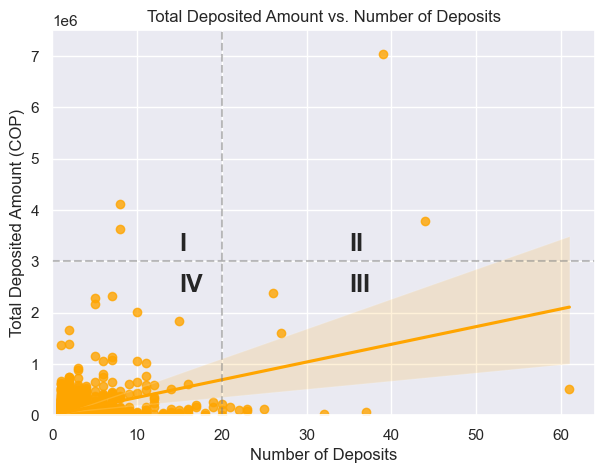

In [17]:
# Create the figure and subplots
fig, ax = plt.subplots(figsize=(7, 5))

# Plot the scatter plot
sns.regplot(x="deposit_count", y="total_deposits",
            data=users, color=colors[4], ax=ax)

# Divide the plot into four quadrants
ax.axvline(x=20, color="grey", linestyle="--", alpha=0.5)
ax.axhline(y=3000000, color="grey", linestyle="--", alpha=0.5)
ax.text(15, 3200000, "I", fontsize=18, fontweight="bold")
ax.text(35, 3200000, "II", fontsize=18, fontweight="bold")
ax.text(35, 2400000, "III", fontsize=18, fontweight="bold")
ax.text(15, 2400000, "IV", fontsize=18, fontweight="bold")

# Set the labels and title
ax.set_xlabel("Number of Deposits")
ax.set_ylabel("Total Deposited Amount (COP)")
ax.set_title("Total Deposited Amount vs. Number of Deposits")

# Set the limits for the x-axis and y-axis
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=7500000)

# Show the plot
plt.show()


This graph illustrates the variety in deposit habits of Coink users. We observe that four users have deposited a large amount of money (Quadrants I and II), two of whom did so in only a few deposits (Quadrant I), while the other two did so in many deposits (Quadrant II). In Quadrant III, users tend to deposit numerous small amounts.

- **Total Deposited Amount, Number of Deposits and Average Deposit Amount vs. Customer Tenure :**


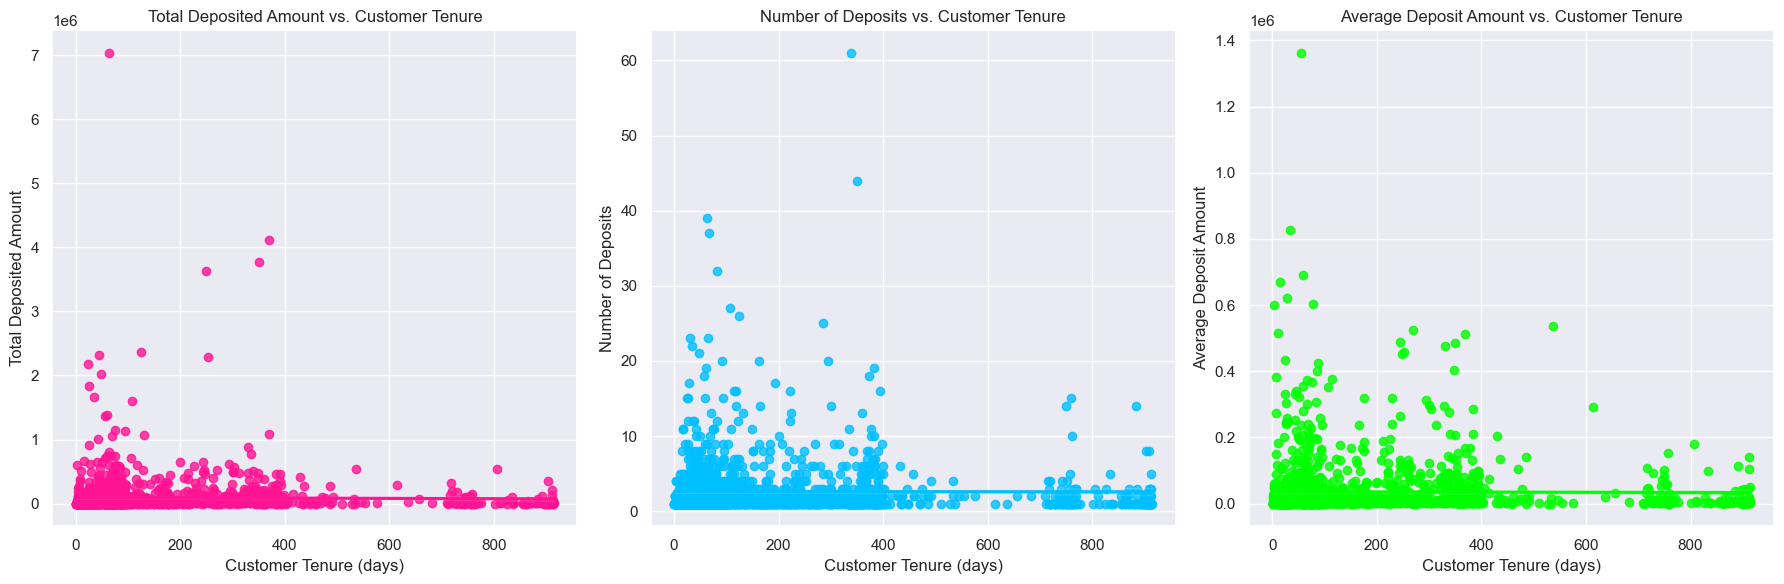

In [18]:
# Create the figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot the first graph in the first subplot
sns.regplot(
    x="customer_tenure", y="total_deposits", data=users, color=colors[0], ax=axs[0]
)
axs[0].set_xlabel("Customer Tenure (days)")
axs[0].set_ylabel("Total Deposited Amount")
axs[0].set_title("Total Deposited Amount vs. Customer Tenure")

# Plot the second graph in the second subplot
sns.regplot(
    x="customer_tenure", y="deposit_count", data=users, color=colors[3], ax=axs[1]
)
axs[1].set_xlabel("Customer Tenure (days)")
axs[1].set_ylabel("Number of Deposits")
axs[1].set_title("Number of Deposits vs. Customer Tenure")

# Plot the third graph in the third subplot
sns.regplot(
    x="customer_tenure",
    y="average_deposit_amount",
    data=users,
    color=colors[2],
    ax=axs[2],
)
axs[2].set_xlabel("Customer Tenure (days)")
axs[2].set_ylabel("Average Deposit Amount")
axs[2].set_title("Average Deposit Amount vs. Customer Tenure")

# Adjust the spaces between the subplots and show the figure
fig.tight_layout()
plt.show()


This graph shows a negative correlation between a customer's tenure and the number of deposits, the total amount of deposits, and the average deposit amount. In other words, as the customer has more time on the platform, their tendency to deposit decreases. It is possible that newer customers have more trust in the product and the company due to improved marketing or positive referrals from other users. Additionally, the fact that there were very few new customers during a period and then a significant increase support the idea of an improved customer acquisition strategy.

- **Average Deposit Amount vs. Frequency:**


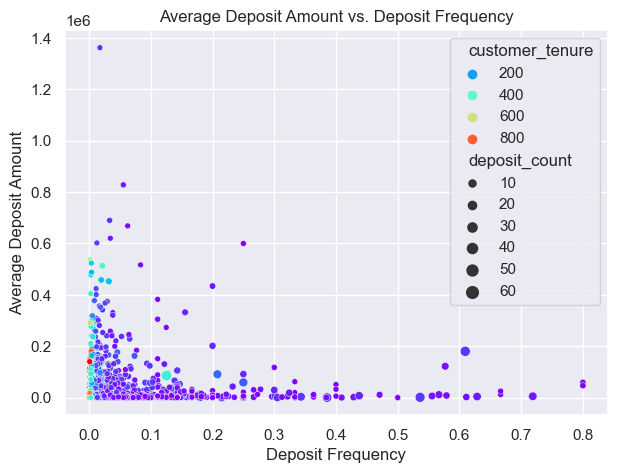

In [19]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x="deposit_frequency",
    y="average_deposit_amount",
    size="deposit_count",
    hue="customer_tenure",
    data=users,
    palette="rainbow",
)
plt.xlabel("Deposit Frequency")
plt.ylabel("Average Deposit Amount")
plt.title("Average Deposit Amount vs. Deposit Frequency")
plt.show()


This is probably the most important graph. We can say that there is a great variety in the way users deposit their money, which could be due to different savings goals and different abilities to achieve them. Most users deposit with low frequency and low amounts, which may indicate that they use Coink as a long-term savings tool rather than making regular deposits. There are also some users who deposit with high frequency but low amount, which may indicate that they use Coink to manage their daily finances. Some users deposit with low frequency but large amounts, indicating that they trust Coink and use it as a long-term savings tool. Finally, there are few users who deposit with high frequency and high amount, indicating that they are valuable users that we should try to attract and retain.

# **Introducing the Coink User Performance Index (CUPI)**

Our goal is to identify users who are performing well according to Coink's prototype of a good customer: someone who has a high deposit frequency, a high average deposit amount, and who has been making deposits for a long time.

To achieve this goal, we propose the Coink User Performance Index (CUPI):

$$CUPI = \frac{C_1 \times \text{average deposit amount} + C_2 \times \text{deposit frequency}}{K}$$

Where:

- average deposit amount is the average amount of each deposit made by the user. We believe that this metric is a good indicator of the user's financial capacity and willingness to save. We use this metric instead of the total amount of deposits made by the user, as we want to give more weight to users who are consistently making larger deposits.
- deposit frequency is the frequency at which the user makes deposits. This metric is a good indicator of the user's commitment to saving and their engagement with the Coink platform.
- $C_1$ and $C_2$ are constants that represent the weights given to average_deposit_amount and deposit_frequency, respectively. We can adjust these constants depending on Coink's business goals and priorities. For example, if Coink wants to prioritize customer loyalty and retention, they may assign a higher weight to customer tenure. On the other hand, if Coink wants to encourage users to deposit more frequently, they may assign a higher weight to deposit frequency.
- $K$ is a normalization factor that ensures that CUPI values are comparable across users. We can set this factor to the maximum possible value of CUPI, which occurs when a user has the highest possible values of average_deposit_amount and deposit_frequency.

Using this metric, we can rank Coink users based on their CUPI score, allowing us to identify high-performing users and target them with tailored incentives or promotions to encourage continued engagement with the platform. Additionally, we can use the CUPI score to track overall user performance over time, identifying trends and making adjustments to Coink's product and marketing strategy as needed.

### Evaluating Coink Users with CUPI

To define the constants $C_1$ and $C_2$, we need to establish our priorities. As an initial hypothesis, we believe that frequency should be given more importance, since it is an essential factor in determining a user's saving pattern. Additionally, we need to create a new column called "first_2weeks_user" to rate the newest users based solely on the amount of money they deposit, not on their frequency or tenure, as two weeks is too little time to define a saving pattern.


In [20]:
users["first_2weeks_user"] = users["customer_tenure"].apply(
    lambda x: 1 if x <= 14 else 0
)

users["normalized_average_deposit_amount"] = (
    users["average_deposit_amount"] / users["average_deposit_amount"].max()
)
users["normalized_deposit_frequency"] = (
    users["deposit_frequency"] / users["deposit_frequency"].max()
)


def apply_clv(row):
    if row["first_2weeks_user"] == 1:
        # set the coefficients and constant for the CUPI equation for first two weeks users
        C1, K = 1, 0.01
        return (C1 * row["normalized_average_deposit_amount"]) / K
    else:
        C1, C2, K = 0.4, 0.6, 0.01
        return (
            C1 * row["normalized_average_deposit_amount"]
            + C2 * row["normalized_deposit_frequency"]
        ) / K


# calculate the CUPI for each user
users["CUPI"] = users.apply(apply_clv, axis=1)

# drop the normalized columns
users.drop(
    ["normalized_average_deposit_amount", "normalized_deposit_frequency"],
    axis=1,
    inplace=True,
)
# Display the top 5 users by CUPI
top_users = users.sort_values(by="CUPI", ascending=False)
top_users.head(5)

,user_id,total_deposits,average_deposit_amount,deposit_count,deposit_frequency,customer_tenure,days_since_last_deposit,americas_percentage,andes_percentage,molinos_percentage,first_2weeks_user,CUPI
199,2b9d276a-54e5-4837-ab8d-cd7ec0e89ea5,126350.0,5493.478261,23,0.718750,31,0,0.0,0.0,1.0,0,54.067597
131,2df8831e-a37a-4ba7-b8f0-ec7c313d68af,7032500.0,180320.512821,39,0.609375,63,15,1.0,0.0,0.0,0,50.999270
18,970cb0ff-1243-4066-8eae-22174f1a5e1d,99400.0,4518.181818,22,0.628571,34,1,0.0,0.0,1.0,0,47.275559
6,9fe4047c-e718-4da6-8fd5-080f46fc2e2f,1834050.0,122270.000000,15,0.576923,25,4,1.0,0.0,0.0,0,46.860390
216,a65bdad2-79ab-44c3-895f-34eb42da7053,28550.0,2595.454545,11,0.611111,17,0,0.0,1.0,0.0,0,45.909564


### Segmenting Coink Users with K-means

Firstly, we need to determine the optimal number of clusters for our user dataframe.


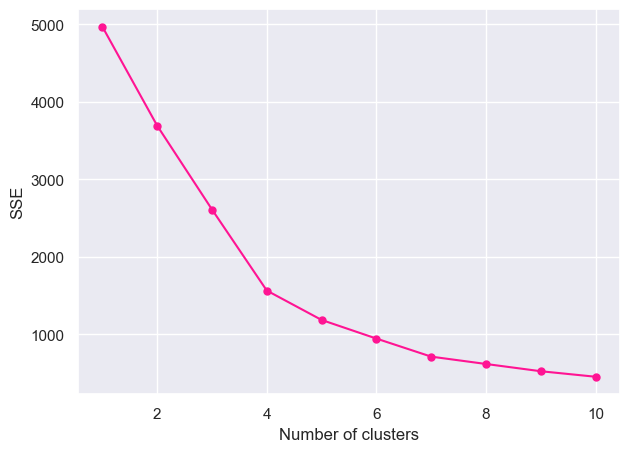

In [21]:
# Select the variables to be used for segmentation
X = users[["average_deposit_amount", "deposit_frequency", "customer_tenure"]]

# Standardize the variables
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Use the elbow method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_std)
    sse.append(kmeans.inertia_)
plt.figure(figsize=(7, 5))
plt.plot(range(1, 11), sse, colors[0], marker="o", markersize=5)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()


In [22]:
# Find the elbow point
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("The optimal number of clusters is:", kl.elbow)


The optimal number of clusters is: 4


### Visualizing Clusters and CUPI


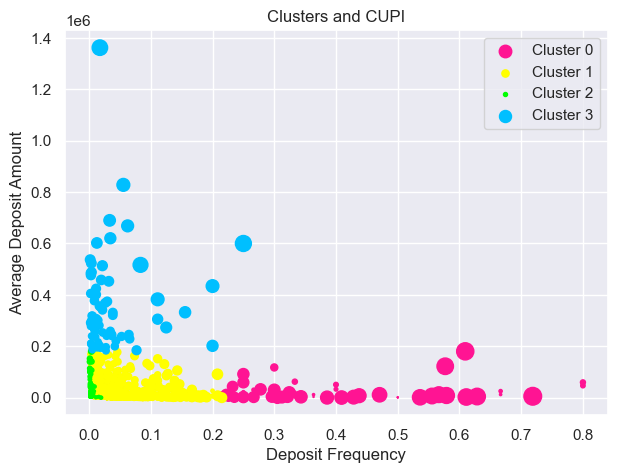

cluster,0,1,2,3
CUPI,16.107940,2.870808,0.765836,13.012976
average_deposit_amount,19339.817446,20815.378525,19099.983318,341116.764347
deposit_frequency,0.398458,0.035696,0.002731,0.033469
customer_tenure,22.015625,131.535004,784.866242,148.576923
days_since_last_deposit,3.796875,36.710391,28.573248,36.320513
americas_percentage,0.375000,0.373229,0.305732,0.948718
andes_percentage,0.140625,0.102112,0.636943,0.000000
molinos_percentage,0.484375,0.524659,0.057325,0.051282


In [23]:
# Segment the users using KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
users["cluster"] = kmeans.fit_predict(X_std)

# Evaluate each segment
results = pd.pivot_table(
    users,
    index=["cluster"],
    values=[
        "average_deposit_amount",
        "deposit_frequency",
        "customer_tenure",
        "days_since_last_deposit",
        "americas_percentage",
        "andes_percentage",
        "molinos_percentage",
        "CUPI",
    ],
)
results = results.reindex(
    columns=[
        "CUPI",
        "average_deposit_amount",
        "deposit_frequency",
        "customer_tenure",
        "days_since_last_deposit",
        "americas_percentage",
        "andes_percentage",
        "molinos_percentage",
    ]
)

fig, ax = plt.subplots(figsize=(7, 5))
for i, cluster in enumerate(np.unique(kmeans.labels_)):
    ax.scatter(
        x=users.loc[users["cluster"] == cluster, "deposit_frequency"],
        y=users.loc[users["cluster"] == cluster, "average_deposit_amount"],
        s=users.loc[users["cluster"] == cluster, "CUPI"] * 3,
        label=f"Cluster {cluster}",
        color=colors[i],
    )
ax.set_xlabel("Deposit Frequency")
ax.set_ylabel("Average Deposit Amount")
ax.set_title("Clusters and CUPI")
ax.legend()
plt.show()

results.T

The results show that we have four significant user segments, each with well-defined deposit habits. The first cluster (Cluster 0) has the highest average CUPI and is composed of relatively new customers. Although the average deposit amount is low, their deposit frequency is very high. Cluster 3 is characterized by high deposit amounts, and it is the second cluster with the highest CUPI. These users usually deposit at CC Plaza Las Américas. Cluster 2 consists of users with an intermediate deposit frequency and low deposit amounts, which makes sense since most of these users are university students. Finally, we observe an interesting trend in Cluster 1, which is composed of the oldest users and is characterized by a low deposit frequency. This indicates that we need to focus on recovering this segment of users.
